## This notebook is for Part d of the project.

Name: Xi Chen
<br>
Github Username: Alicella
<br>
USC ID: 8869487524

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
# from tqdm import tqdm
# from skimage import io
# import cv2
import matplotlib.pyplot as plt

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('../data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

## Loading and pre processing the data
<!-- Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results. -->

In [4]:
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
import tensorflow.keras as keras
from PIL import Image 


def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        
        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        
        # Convert PIL image to numpy array
        img = np.array(img)
        # img = tf.image.resize(img, [299, 299]) 
        img = tf.image.resize(img, (224, 224)) # expected input images size for transfer learning models

        # Normalize the image to the [0, 1] range
        img = img / 255.0

        label = 1 if label_str=='frost' else 0
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    # Set the shape of the tensors
    X.set_shape([224, 224, 3])              # expected input images size for transfer learning models
    y.set_shape([])  # Scalar label

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 8

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)


tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

## (d) Transfer learning

### Image augmentation

In [5]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"), 
  layers.RandomRotation(0.2),
  layers.RandomContrast(factor=0.5),  # Adjust contrast
  layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  # Translate horizontally and vertically
  # layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),  # Zoom into or out of the image
  # layers.RandomCrop(height=cropped_height, width=cropped_width)  # Randomly crop the image
])

### Using EfficientNetB0 

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard    # tensorboard --logdir logs
from tensorflow.keras.optimizers.legacy import Adam
import time
from tensorflow.keras.applications import EfficientNetB0
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
# INPUT_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
NUM_CLASSES = 2  # frost or background

base_model_en = EfficientNetB0(weights='imagenet', include_top=False, pooling='max')

# freeze all layers before the second last one
for layer in base_model_en.layers[:-2]:
    layer.trainable = False

model_en = Sequential()

# Randomly decide whether to augment the image
# should_augment = tf.random.uniform(shape=[], minval=0, maxval=1) < 0.4  # 40% chance of augmentation
# if should_augment:
model_en.add(data_augmentation)

model_en.add(base_model_en)
model_en.add(Dropout(0.2))

# Add global average pooling layer
# model_en.add(GlobalAveragePooling2D())            give error

model_en.add(Flatten())

# Dense layer with dropout and L2 regularization
model_en.add(Dense(64, kernel_regularizer=regularizers.l2(0.0001)))
model_en.add(BatchNormalization())
model_en.add(Activation('relu'))
model_en.add(Dropout(0.3))

model_en.add(Dense(NUM_CLASSES, activation='softmax'))
# model_en.add(Dense(1, activation='sigmoid'))

customize_optimizer = Adam(learning_rate=0.4)
model_en.compile(optimizer=customize_optimizer,     # optimizer='adam'   
              loss='sparse_categorical_crossentropy', 
                # loss = 'binary_crossentropy',
                metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_en = model_en.fit(tf_dataset_train, epochs=10, validation_data=tf_dataset_val, callbacks=[early_stopping])

model_en.summary()

Epoch 1/20
3710/3710 [==============================] - 928s 248ms/step - loss: 5.0688 - accuracy: 0.5490 - val_loss: 1.9935 - val_accuracy: 0.3218
Epoch 2/20
3710/3710 [==============================] - 909s 245ms/step - loss: 0.8916 - accuracy: 0.5450 - val_loss: 1.2986 - val_accuracy: 0.3218
Epoch 3/20
3710/3710 [==============================] - 911s 246ms/step - loss: 0.7104 - accuracy: 0.5470 - val_loss: 0.8807 - val_accuracy: 0.3218
Epoch 4/20
3710/3710 [==============================] - 992s 267ms/step - loss: 0.7083 - accuracy: 0.5460 - val_loss: 0.8850 - val_accuracy: 0.3218
Epoch 5/20
3710/3710 [==============================] - 911s 245ms/step - loss: 0.7105 - accuracy: 0.5460 - val_loss: 0.6505 - val_accuracy: 0.6782
Epoch 6/20
3710/3710 [==============================] - 910s 245ms/step - loss: 0.7110 - accuracy: 0.5475 - val_loss: 0.8778 - val_accuracy: 0.3218
Epoch 7/20
3710/3710 [==============================] - 526s 142ms/step - loss: 0.7077 - accuracy: 0.5454 - val_

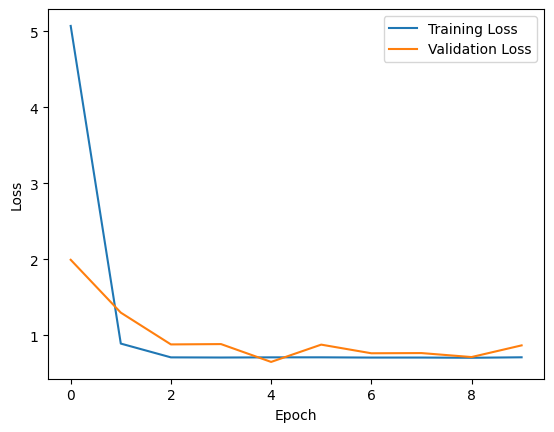

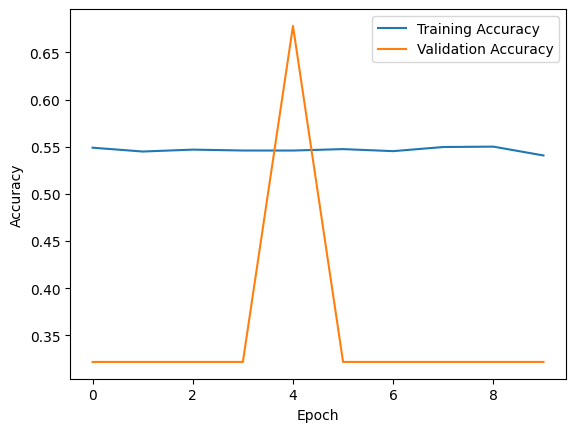

In [13]:
# Plot training and validation loss over epochs
plt.plot(history_en.history['loss'], label='Training Loss')
plt.plot(history_en.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy over epochs
plt.plot(history_en.history['accuracy'], label='Training Accuracy')
plt.plot(history_en.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Evaluation

In [14]:
from sklearn.metrics import classification_report

true_labels = []
for images, labels in tf_dataset_test.unbatch():
    true_labels.append(labels.numpy())

true_labels = np.array(true_labels).flatten()

predicted_labels = []
predicted_probs = model_en.predict(tf_dataset_test)
for prob in predicted_probs:
    if prob[0] > prob[1]:
        predicted_labels.append(0)
    else:
        predicted_labels.append(1)

report_en = classification_report(true_labels, predicted_labels)
print(report_en)


1603/1603 [==============================] - 140s 86ms/step
              precision    recall  f1-score   support

           0       0.34      1.00      0.51      4418
           1       0.00      0.00      0.00      8405

    accuracy                           0.34     12823
   macro avg       0.17      0.50      0.26     12823
weighted avg       0.12      0.34      0.18     12823



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [15]:
evaluation_result = model_en.evaluate(tf_dataset_test)
test_loss, test_accuracy = evaluation_result
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

1603/1603 [==============================] - 144s 90ms/step - loss: 0.7519 - accuracy: 0.3445
Test loss: 0.7519264817237854
Test accuracy: 0.3445371687412262


### Using ResNet50

In [7]:
from tensorflow.keras.applications import ResNet50
NUM_CLASSES = 2

# Load the pre-trained ResNet50 model without the top layer
base_model_rs = ResNet50(weights='imagenet', include_top=False)

# Freeze all layers in the base model
for layer in base_model_rs.layers:
    layer.trainable = False

model_rs = Sequential()

model_rs.add(data_augmentation)

model_rs.add(base_model_rs)

# model_rs.add(Flatten())
# Add global average pooling layer
model_rs.add(GlobalAveragePooling2D())

# Dense layer with dropout and L2 regularization
model_rs.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
model_rs.add(BatchNormalization())
model_rs.add(Activation('relu'))
model_rs.add(Dropout(0.3))

model_rs.add(Dense(NUM_CLASSES, activation='softmax'))
# model_rs.add(Dense(1, activation='sigmoid'))

customize_optimizer = Adam(learning_rate=0.0001)
model_rs.compile(optimizer=customize_optimizer,   #optimizer='adam',     
              loss='sparse_categorical_crossentropy', 
                # loss = 'binary_crossentropy',
                metrics=['accuracy'])
 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_rs = model_rs.fit(tf_dataset_train, epochs=10, validation_data=tf_dataset_val, callbacks=[early_stopping])

model_rs.summary()

Epoch 1/10
3710/3710 [==============================] - 575s 154ms/step - loss: 0.8396 - accuracy: 0.6995 - val_loss: 0.8146 - val_accuracy: 0.7729
Epoch 2/10
3710/3710 [==============================] - 600s 162ms/step - loss: 0.6052 - accuracy: 0.7211 - val_loss: 5.5691 - val_accuracy: 0.3218
Epoch 3/10
3710/3710 [==============================] - 615s 166ms/step - loss: 0.5776 - accuracy: 0.7275 - val_loss: 2.9030 - val_accuracy: 0.3223
Epoch 4/10
3710/3710 [==============================] - 627s 169ms/step - loss: 0.5696 - accuracy: 0.7314 - val_loss: 4.7402 - val_accuracy: 0.3220
Epoch 5/10
3710/3710 [==============================] - 643s 173ms/step - loss: 0.5592 - accuracy: 0.7375 - val_loss: 0.4934 - val_accuracy: 0.7630
Epoch 6/10
3710/3710 [==============================] - 660s 178ms/step - loss: 0.5529 - accuracy: 0.7401 - val_loss: 7.3578 - val_accuracy: 0.3218
Epoch 7/10
3710/3710 [==============================] - 663s 179ms/step - loss: 0.5482 - accuracy: 0.7413 - val_

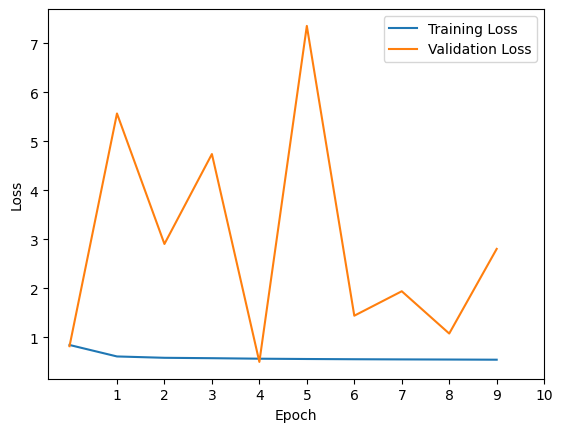

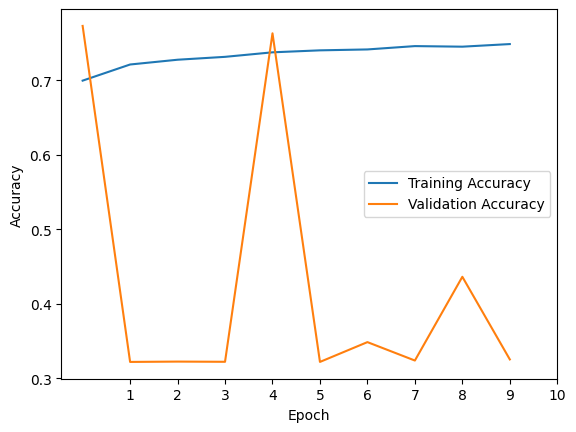

In [17]:
# Plot training and validation loss over epochs
plt.plot(history_rs.history['loss'], label='Training Loss')
plt.plot(history_rs.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(history_rs.history['accuracy']) + 1)) 
plt.legend()
plt.show()

# Plot training and validation accuracy over epochs
plt.plot(history_rs.history['accuracy'], label='Training Accuracy')
plt.plot(history_rs.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(history_rs.history['accuracy']) + 1)) 
plt.legend()
plt.show()

In [ ]:
predicted_labels = []
predicted_probs = model_rs.predict(tf_dataset_test)
for prob in predicted_probs:
    if prob[0] > prob[1]:
        predicted_labels.append(0)
    else:
        predicted_labels.append(1)

In [9]:
evaluation_result = model_rs.evaluate(tf_dataset_test)
test_loss, test_accuracy = evaluation_result
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

1603/1603 [==============================] - 156s 97ms/step - loss: 0.8863 - accuracy: 0.5322
Test loss: 0.8862651586532593
Test accuracy: 0.5321687459945679


In [11]:
from sklearn.metrics import classification_report

true_labels = []
for images, labels in tf_dataset_test.unbatch():
    true_labels.append(labels.numpy())

true_labels = np.array(true_labels).flatten()
report_rs = classification_report(true_labels, predicted_labels)
print(report_rs)

              precision    recall  f1-score   support

           0       0.35      0.72      0.47      4418
           1       0.66      0.29      0.40      8405

    accuracy                           0.44     12823
   macro avg       0.51      0.51      0.44     12823
weighted avg       0.56      0.44      0.43     12823



### Using VGG16

In [12]:
from tensorflow.keras.applications import VGG16
NUM_CLASSES = 2
# Load the pre-trained VGG16 model without the top layer
base_model_vg = VGG16(weights='imagenet', include_top=False)

# Freeze all layers in the base model
for layer in base_model_vg.layers:
    layer.trainable = False


model_vg = Sequential()

# Randomly decide whether to augment the image
# should_augment = tf.random.uniform(shape=[], minval=0, maxval=1) < 0.4  # 40% chance of augmentation
# if should_augment:
model_vg.add(data_augmentation)

model_vg.add(base_model_vg)

# model_rs.add(Flatten())
model_vg.add(GlobalAveragePooling2D())

model_vg.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
model_vg.add(BatchNormalization())
model_vg.add(Activation('relu'))
model_vg.add(Dropout(0.3))

model_vg.add(Dense(NUM_CLASSES, activation='softmax'))
# model_vg.add(Dense(1, activation='sigmoid'))

# customize_optimizer = Adam(learning_rate=0.5)
model_vg.compile(optimizer='adam',      #optimizer=customize_optimizer,   
              loss='sparse_categorical_crossentropy', 
                # loss = 'binary_crossentropy',
                metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_vg = model_vg.fit(tf_dataset_train, epochs=10, validation_data=tf_dataset_val, callbacks=[early_stopping])

model_vg.summary()

Epoch 1/10
3710/3710 [==============================] - 877s 236ms/step - loss: 0.6361 - accuracy: 0.7585 - val_loss: 0.7940 - val_accuracy: 0.6247
Epoch 2/10
3710/3710 [==============================] - 894s 241ms/step - loss: 0.5270 - accuracy: 0.7666 - val_loss: 0.4282 - val_accuracy: 0.8615
Epoch 3/10
3710/3710 [==============================] - 942s 254ms/step - loss: 0.5031 - accuracy: 0.7732 - val_loss: 0.4765 - val_accuracy: 0.8016
Epoch 4/10
3710/3710 [==============================] - 956s 258ms/step - loss: 0.4930 - accuracy: 0.7822 - val_loss: 0.5629 - val_accuracy: 0.7178
Epoch 5/10
3710/3710 [==============================] - 947s 255ms/step - loss: 0.4839 - accuracy: 0.7871 - val_loss: 0.3617 - val_accuracy: 0.8683
Epoch 6/10
3710/3710 [==============================] - 982s 265ms/step - loss: 0.4830 - accuracy: 0.7893 - val_loss: 0.5994 - val_accuracy: 0.7050
Epoch 7/10
3710/3710 [==============================] - 1008s 272ms/step - loss: 0.4785 - accuracy: 0.7873 - val

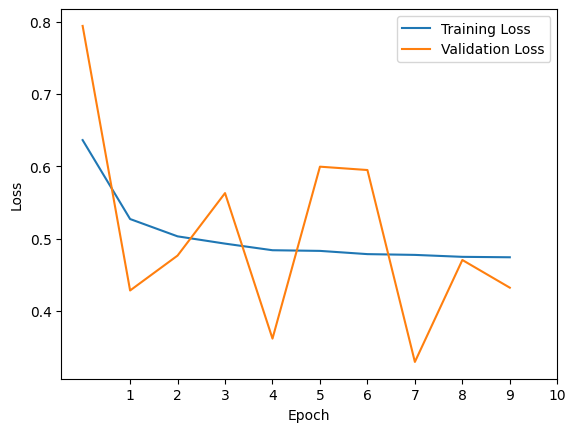

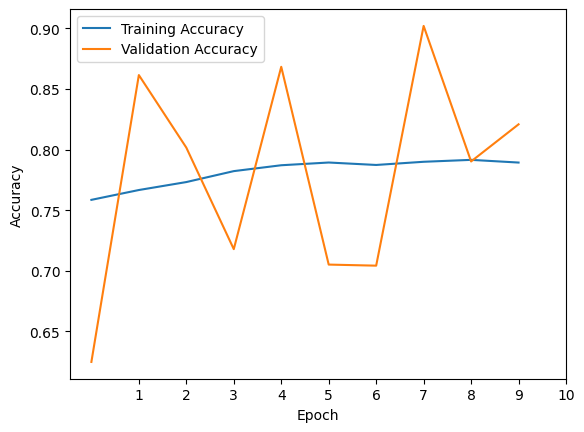

In [13]:
# Plot training and validation loss over epochs
plt.plot(history_vg.history['loss'], label='Training Loss')
plt.plot(history_vg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(history_vg.history['accuracy']) + 1)) 
plt.legend()
plt.show()

# Plot training and validation accuracy over epochs
plt.plot(history_vg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(history_vg.history['accuracy']) + 1)) 
plt.legend()
plt.show()

In [15]:
predicted_labels = []
predicted_probs = model_vg.predict(tf_dataset_test)
for prob in predicted_probs:
    if prob[0] > prob[1]:
        predicted_labels.append(0)
    else:
        predicted_labels.append(1)

report_vg = classification_report(true_labels, predicted_labels)
print(report_vg)

1603/1603 [==============================] - 233s 145ms/step
              precision    recall  f1-score   support

           0       0.35      0.43      0.38      4418
           1       0.66      0.58      0.61      8405

    accuracy                           0.52     12823
   macro avg       0.50      0.50      0.50     12823
weighted avg       0.55      0.52      0.53     12823



In [16]:
evaluation_result = model_vg.evaluate(tf_dataset_test)
test_loss, test_accuracy = evaluation_result
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

1603/1603 [==============================] - 256s 160ms/step - loss: 0.5039 - accuracy: 0.7966
Test loss: 0.5039324164390564
Test accuracy: 0.796615481376648


## Comparison


- Transfer learning overall performs worse than CNN + MLP.  
- VGG16 works the best among all three pre-trained models, but the test accuracy 79.7% is much lower than CNN + MLP's 94.8%.  
- EfficientNetB0 is not learning at all in my current parameter setting.  
- ResNet50 learns a little but performed worse than VGG. 